In [1]:
!pip install torch
!pip install torchvision

In [2]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV,cross_validate,train_test_split
import matplotlib.pyplot as plt

In [3]:
transformer = transforms.Compose([
                               torchvision.transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x)),
                             ])

In [4]:
train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train= len(train_set)//5
batch_size_test=len(test_set)

In [5]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [6]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [10]:
train_x.shape

torch.Size([12000, 784])

In [8]:
train_x[1].shape

torch.Size([784])

# Models


In [20]:
model_lbls = [
              'Polynomial', 'RBF', 'Sigmoid','Linear' 
            ]

models = {
    'Polynomial': {'name': 'SVM Polynomial Kernel',
           'estimator': SVC(kernel='poly'), 
           'param': [{'degree': [8]}],
          },
    'RBF': {'name': 'SVM RBF Kernel',
           'estimator': SVC(kernel= 'rbf'),
           'param': [{}]
          },
    'Sigmoid': {'name': 'SVM Sigmoid Kernel',
           'estimator': SVC(kernel= 'sigmoid'),
           'param': [{}],
          },
    'Linear':{'name': 'SVM Linear Kernel',
           'estimator': SVC(kernel= 'linear'), 
           'param': [{}]
          },
}

scores = ['precision', 'recall','f1']

In [7]:
def print_results(model):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    true_y, pred_y = test_y, model.predict(test_x)
    print(classification_report(true_y, pred_y))
    print()

In [8]:

def evaluate_models(models):
    results_short = {}
    for score in scores:
        print('='*40)
        print("# Tuning hyper-parameters for %s" % score)
        print()

        for m in model_lbls:
            print('-'*40)
            print("Trying model {}".format(models[m]['name']))
            clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                               scoring='%s_macro' % score, 
                               return_train_score = False,
                               n_jobs = 2, 
                               )
            clf.fit(train_x, train_y)
            print_results(clf)
            results_short[m] = clf.best_score_
        print("Summary of results for {}".format(score))
        print("Estimator")
        for m in results_short.keys():
            print("{}\t - score: {:4.2}%".format(models[m]['name'], results_short[m]))

In [21]:
evaluate_models(models)

# Tuning hyper-parameters for precision

----------------------------------------
Trying model SVM Polynomial Kernel
Best parameters set found on train set:

{'degree': 8}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.82      0.65      0.73      1000
           1       0.96      0.87      0.91      1000
           2       0.69      0.59      0.64      1000
           3       0.87      0.70      0.78      1000
           4       0.75      0.67      0.71      1000
           5       0.42      0.95      0.58      1000
           6       0.56      0.50      0.53      1000
           7       0.90      0.66      0.76      1000
           8       0.93      0.85      0.89      1000
           9       0.93      0.89      0.91      1000

    accuracy                           0.73     1000

Best parameters set found on train set:

{'degree': 8}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.82      0.65      0.73      1000
           1       0.96      0.87      0.91      1000
           2       0.69      0.59      0.64      1000
           3       0.87      0.70      0.78      1000
           4       0.75      0.67      0.71      1000
           5       0.42      0.95      0.58      1000
           6       0.56      0.50      0.53      1000
           7       0.90      0.66      0.76      1000
           8       0.93      0.85      0.89      1000
           9       0.93      0.89      0.91      1000

    accuracy                           0.73     10000
   macro avg       0.78      0.73      0.74     10000
weighted avg       0.78      0.73      0.74     10000


-----

As we can see the Linear and RBF kernels outperform the Sigmoid by a big margin. The Polynomial kernel, on the other hand isn't far off from them, meaning it's results could be better by ajusting the input parameters of the degree.

In [36]:
models = {
    'Polynomial': {'name': 'SVM Polynomial Kernel',
           'estimator': SVC(), 
           'param': [{
                   'kernel':["poly"],
                   'degree': [1,2,3,4,5,6,7,8,9,10],
           }]
          },
    'RBF': {'name': 'SVM RBF Kernel',
           'estimator': SVC(),
           'param': [{
                   'kernel':['rbf'],
                   'C': [0.1,1.0,10.0,100.0],
                    'gamma':[1.0,0.1,0.01,0.001],
               
           }]
          },
    'Linear':{'name': 'SVM Linear Kernel',
           'estimator': SVC(), 
           'param': [{
                    'kernel': ['linear'],
                    'C': [0.1,1.0,10.0,100.0],
           }]
          },
}

model_lbls = ['Polynomial','RBF','Linear']
scores = ['f1']

In [37]:
evaluate_models(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model SVM Polynomial Kernel
Best parameters set found on train set:

{'degree': 2, 'kernel': 'poly'}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1000
           1       0.99      0.95      0.97      1000
           2       0.75      0.73      0.74      1000
           3       0.86      0.85      0.85      1000
           4       0.77      0.73      0.75      1000
           5       0.86      0.94      0.90      1000
           6       0.60      0.60      0.60      1000
           7       0.90      0.90      0.90      1000
           8       0.95      0.94      0.94      1000
           9       0.95      0.92      0.94      1000

    accuracy                           0.

In [11]:
def plot_scores_by_parameter(model,ks,X_train,X_test,y_train,y_test,visualize=True):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = model(k).fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    if visualize:
        plt.figure(figsize=(10, 6))
        plt.plot(ks, train_scores, color='blue', label='train score')
        plt.plot(ks, test_scores, color='green', label='test score')
        plt.legend()
    return train_scores,test_scores

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, random_state=0)

In [37]:
poly_constructor = lambda a: SVC(kernel = "poly",degree = 2,gamma = a)

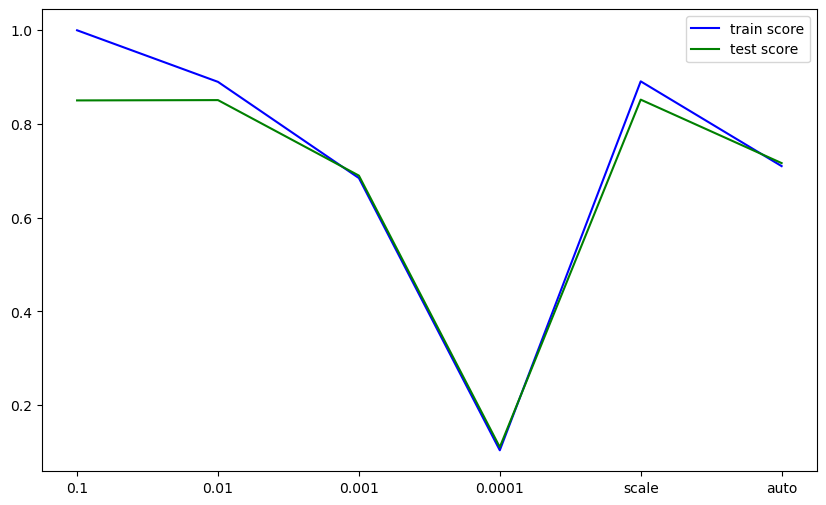

In [12]:
_=plot_scores_by_parameter(poly_constructor,[0.1,0.01,0.001,0.0001,"scale","auto"],X_train,X_valid,y_train,y_valid)

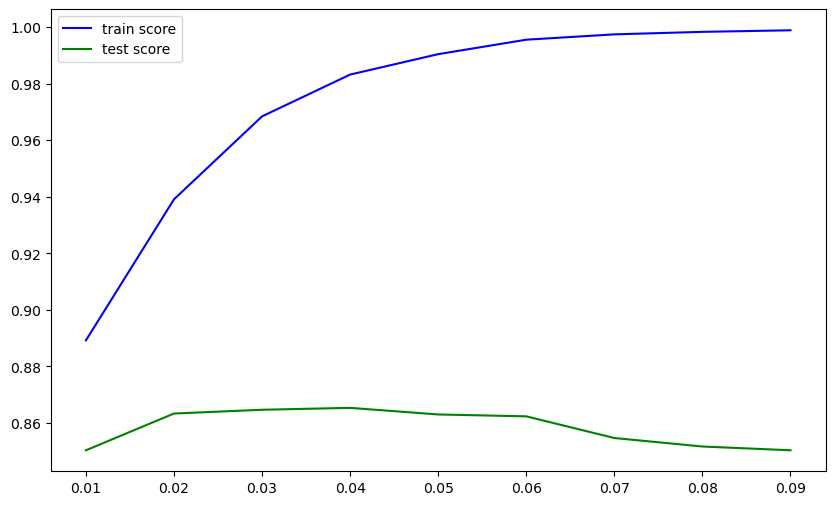

In [38]:
_=plot_scores_by_parameter(poly_constructor,np.arange(0.01,0.1,0.01),X_train,X_valid,y_train,y_valid)

In [47]:
poly_constructor = lambda a: SVC(kernel = "poly",degree = a,gamma = 'scale')

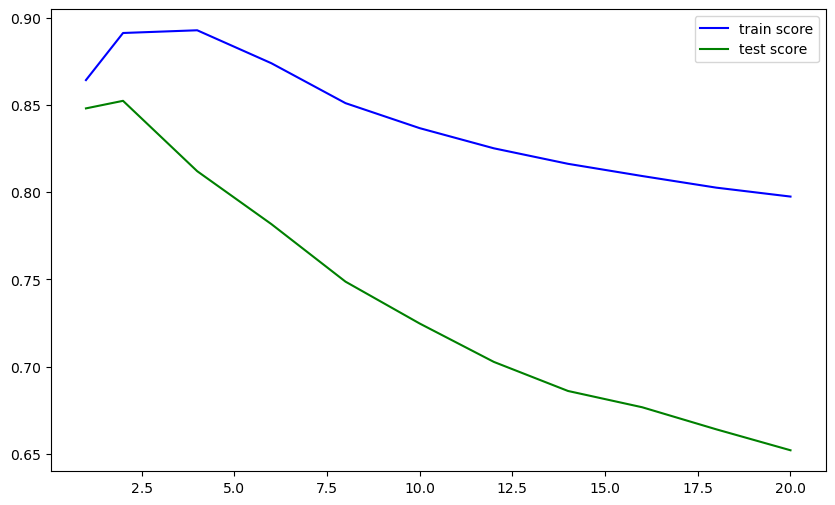

In [50]:
_=plot_scores_by_parameter(poly_constructor,[1,2,4,6,8,10,12,14,16,18,20],X_train,X_valid,y_train,y_valid)

In [39]:
poly_constructor = lambda a: SVC(kernel = "poly",degree = 2,gamma = 'scale', C = a)

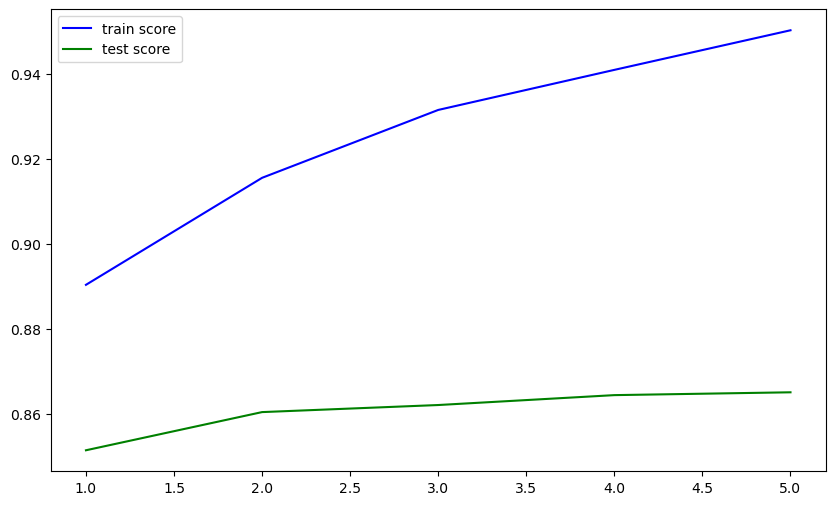

In [40]:
_=plot_scores_by_parameter(poly_constructor,np.arange(1,6,1),X_train,X_valid,y_train,y_valid)

In [14]:
poly_constructor = lambda a: SVC(kernel = "poly",degree = 2,gamma = 'scale',decision_function_shape= a)

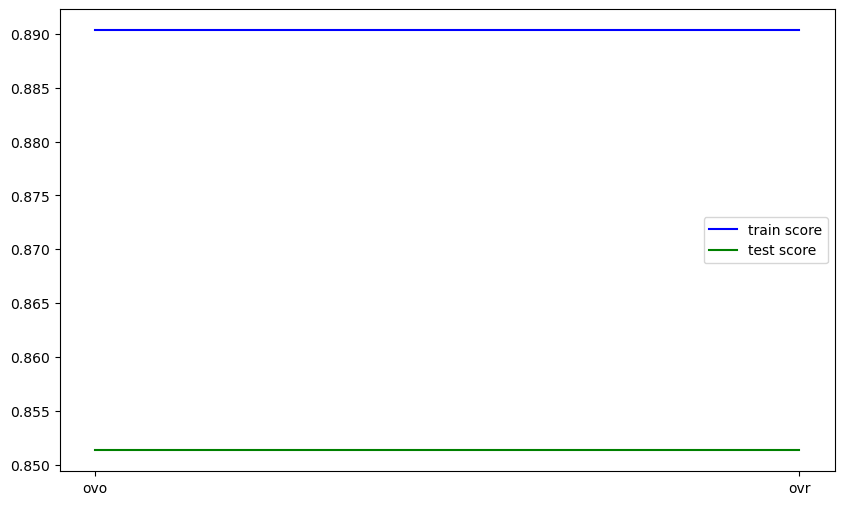

In [15]:
_=plot_scores_by_parameter(poly_constructor,['ovo','ovr'],X_train,X_valid,y_train,y_valid)

In [43]:
poly_constructor = lambda l: SVC(kernel='poly',degree = 2, gamma=l[0], C=l[1])

In [41]:
l1 = np.arange(0.01,0.07,0.01)
l2 = np.arange(1,4,1)
values = list(product(l1, l2))

In [44]:
train_scores,test_scores = plot_scores_by_parameter(poly_constructor,values,X_train,X_valid,y_train,y_valid,visualize=False)

In [45]:
for value,train_score,test_score in zip(values,train_scores,test_scores):
    print(f'gamma={value[0]} C={value[1]}, train score: {train_score}, test_score: {test_score}')

gamma=0.01 C=1, train score: 0.8892222222222222, test_score: 0.8503333333333334
gamma=0.01 C=2, train score: 0.9132222222222223, test_score: 0.859
gamma=0.01 C=3, train score: 0.9304444444444444, test_score: 0.8633333333333333
gamma=0.02 C=1, train score: 0.9391111111111111, test_score: 0.8633333333333333
gamma=0.02 C=2, train score: 0.9641111111111111, test_score: 0.865
gamma=0.02 C=3, train score: 0.9753333333333334, test_score: 0.8663333333333333
gamma=0.03 C=1, train score: 0.9684444444444444, test_score: 0.8646666666666667
gamma=0.03 C=2, train score: 0.9853333333333333, test_score: 0.863
gamma=0.03 C=3, train score: 0.9916666666666667, test_score: 0.8626666666666667
gamma=0.04 C=1, train score: 0.9832222222222222, test_score: 0.8653333333333333
gamma=0.04 C=2, train score: 0.9942222222222222, test_score: 0.8626666666666667
gamma=0.04 C=3, train score: 0.9973333333333333, test_score: 0.8553333333333333
gamma=0.05 C=1, train score: 0.9904444444444445, test_score: 0.863
gamma=0.05 C

RBF Kernel

In [19]:
rbf_constructor = lambda a: SVC(kernel = "rbf", gamma = a)

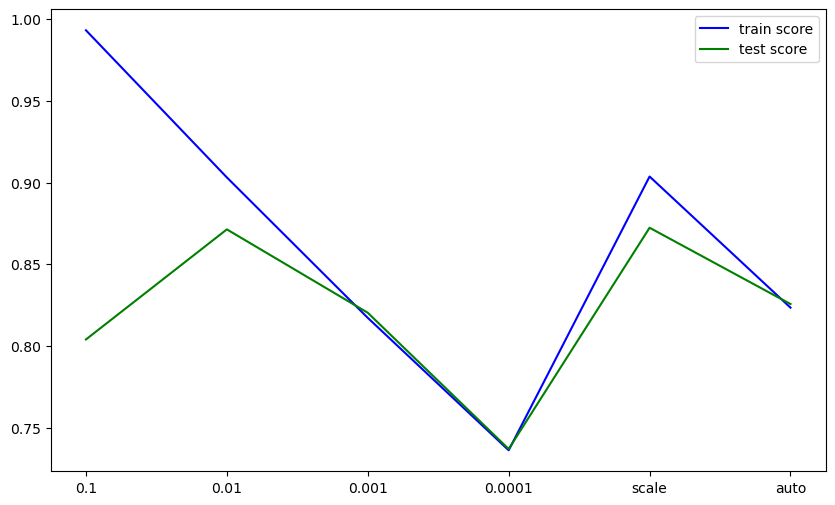

In [20]:
_=plot_scores_by_parameter(rbf_constructor,[0.1,0.01,0.001,0.0001,"scale","auto"],X_train,X_valid,y_train,y_valid)

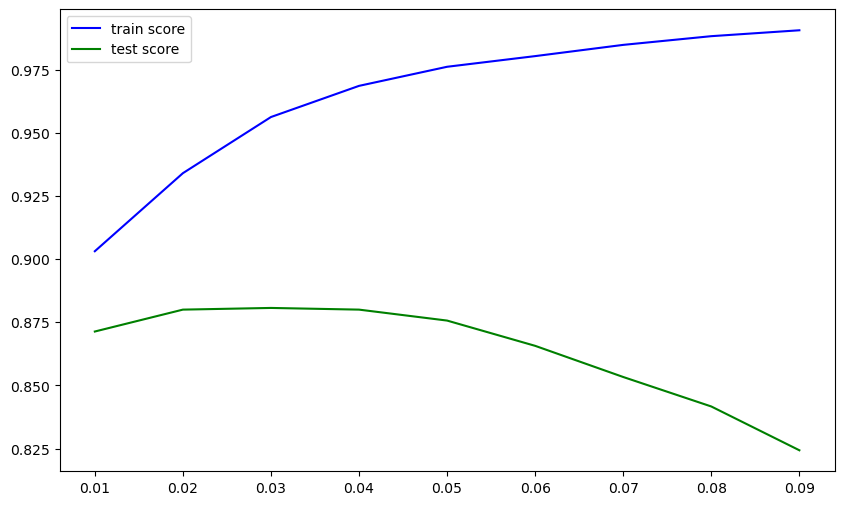

In [21]:
_=plot_scores_by_parameter(rbf_constructor,np.arange(0.01,0.1,0.01),X_train,X_valid,y_train,y_valid)

In [22]:
rbf_constructor = lambda a: SVC(kernel = "rbf", C = a)

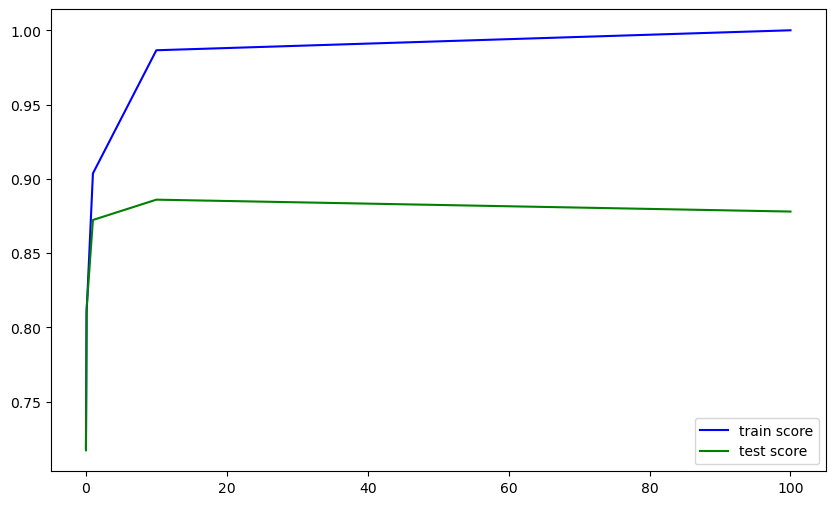

In [23]:
_=plot_scores_by_parameter(rbf_constructor,[0.01,0.1,1,10,100],X_train,X_valid,y_train,y_valid)

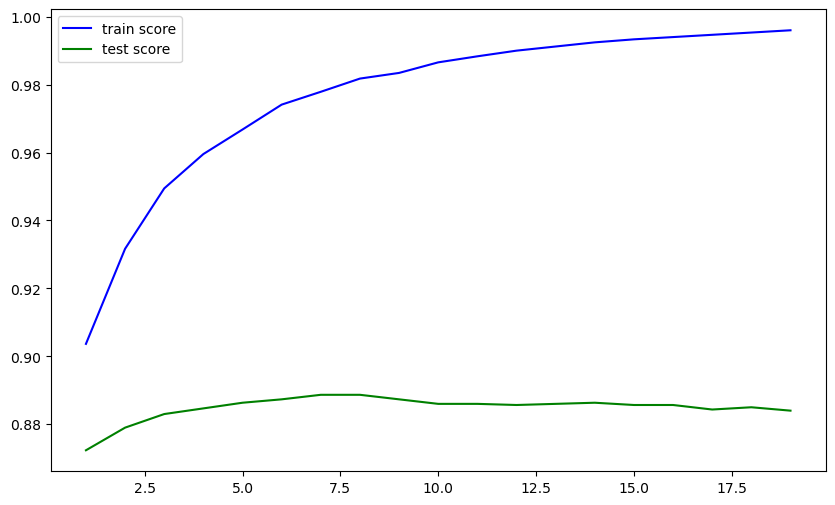

In [24]:
_=plot_scores_by_parameter(rbf_constructor,np.arange(1,20,1),X_train,X_valid,y_train,y_valid)

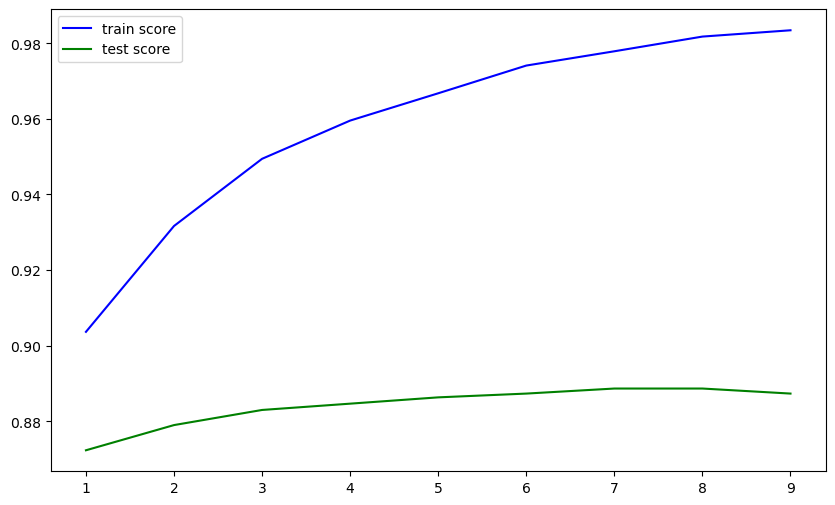

In [25]:
_=plot_scores_by_parameter(rbf_constructor,np.arange(1,10,1),X_train,X_valid,y_train,y_valid)

In [32]:
rbf_constructor = lambda l: SVC(kernel='rbf', gamma=l[0], C=l[1])

In [33]:
from itertools import product

In [34]:
l1 = np.arange(0.01,0.06,0.01)
l2 = np.arange(1,8,1)
values = list(product(l1, l2))

In [35]:
train_scores,test_scores = plot_scores_by_parameter(rbf_constructor,values,X_train,X_valid,y_train,y_valid,visualize=False)

In [36]:
for value,train_score,test_score in zip(values,train_scores,test_scores):
    print(f'gamma={value[0]} C={value[1]}, train score: {train_score}, test_score: {test_score}')

gamma=0.01 C=1, train score: 0.9031111111111111, test_score: 0.8713333333333333
gamma=0.01 C=2, train score: 0.9296666666666666, test_score: 0.879
gamma=0.01 C=3, train score: 0.9477777777777778, test_score: 0.8833333333333333
gamma=0.01 C=4, train score: 0.9582222222222222, test_score: 0.8843333333333333
gamma=0.01 C=5, train score: 0.9656666666666667, test_score: 0.8853333333333333
gamma=0.01 C=6, train score: 0.9732222222222222, test_score: 0.8876666666666667
gamma=0.01 C=7, train score: 0.9763333333333334, test_score: 0.888
gamma=0.02 C=1, train score: 0.934, test_score: 0.88
gamma=0.02 C=2, train score: 0.9668888888888889, test_score: 0.886
gamma=0.02 C=3, train score: 0.9796666666666667, test_score: 0.8913333333333333
gamma=0.02 C=4, train score: 0.9864444444444445, test_score: 0.89
gamma=0.02 C=5, train score: 0.9917777777777778, test_score: 0.889
gamma=0.02 C=6, train score: 0.9948888888888889, test_score: 0.8896666666666667
gamma=0.02 C=7, train score: 0.9955555555555555, test

In [47]:
from sklearn.metrics import classification_report,accuracy_score,f1_score

In [50]:
poly = SVC(kernel='poly',degree=2, gamma=0.03, C=1)
rbf= SVC(kernel='rbf', gamma=0.02, C=1)

poly.fit(train_x,train_y)
rbf.fit(train_x,train_y)

poly_pred = poly.predict(test_x)
rbf_pred = rbf.predict(test_x)

print (f'Polynomial Kernel F1 score = {f1_score(test_y, poly_pred,average="micro")*100}')
print (f'RBF Kernel F1 score = {f1_score(test_y, rbf_pred,average="micro")*100}')

print (f'Polynomial Kernel Classification Report \n {classification_report(test_y, poly_pred, labels=range(0,10))}')
print (f'RBF Classification Report \n {classification_report(test_y, rbf_pred, labels=range(0,10))}')

Polynomial Kernel F1 score = 85.6
RBF Kernel F1 score = 86.58000000000001
Polynomial Kernel Classification Report 
               precision    recall  f1-score   support

           0       0.77      0.83      0.80      1000
           1       0.99      0.97      0.98      1000
           2       0.74      0.79      0.76      1000
           3       0.88      0.86      0.87      1000
           4       0.77      0.76      0.76      1000
           5       0.93      0.95      0.94      1000
           6       0.66      0.59      0.63      1000
           7       0.92      0.94      0.93      1000
           8       0.95      0.94      0.95      1000
           9       0.95      0.93      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

RBF Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.85      0.8

LinearSVC also implements an alternative multi-class strategy, the so-called multi-class SVM formulated by Crammer and Singer, by using the option multi_class='crammer_singer'. In practice, one-vs-rest classification is usually preferred, since the results are mostly similar, but the runtime is significantly less. Using the Crammer and Singer formula is extremely slow for big datasets.

Стигаме до заключението, че гама трябва да е малко число близо до 0.